Fisher or Logistic Regression approach to the downstream tracking.
====================
I would like to use very simple model - Fisher also called Logistic Regresion

The baseline to beat is 0.80457111174771212
-------------

In [1]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


Welcome to JupyROOT 6.07/07


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [2]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [3]:
def replace_transforamtion(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [4]:
data = replace_transforamtion(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.213708,7.841285,7.079410,25.0,0.0,12.0,1263.157617,517.249191,0.524220,0.061572
1,1.346112,7.930741,7.093734,25.0,0.0,12.0,1264.522435,99.363473,0.480288,0.009081
2,1.627632,8.469986,7.443378,25.0,0.0,12.0,1521.093160,196.064807,0.382802,0.025975
3,1.789231,8.556975,7.508752,25.0,0.0,12.0,1563.145597,483.850246,0.369674,0.058753
4,1.269238,7.741082,7.132965,24.0,0.0,12.0,1641.727752,411.084316,0.646627,0.054980


Print the features
-------------------------

In [6]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06
mean,2.151541e+00,2.171630e+00,1.951658e+00,1.778696e+01,2.583371e+00,1.116850e+01,5.329296e+02,3.792155e+02,2.452544e-01,5.047799e-02
std,1.450411e+00,1.155116e-01,7.288195e-02,4.672981e+00,4.624577e+00,1.080491e+00,4.467357e+02,4.158186e+02,2.053685e-01,5.301402e-02
min,2.503011e-04,1.947969e+00,-5.682955e-01,8.000000e+00,0.000000e+00,8.000000e+00,1.936797e-04,8.009404e-04,4.877929e-07,1.786139e-09
25%,1.053873e+00,2.080834e+00,1.922367e+00,1.300000e+01,0.000000e+00,1.100000e+01,1.680454e+02,9.086889e+01,7.756509e-02,1.284370e-02
50%,1.714204e+00,2.158347e+00,1.949358e+00,1.900000e+01,0.000000e+00,1.200000e+01,3.975971e+02,2.159103e+02,1.848496e-01,3.124117e-02
75%,2.949078e+00,2.249934e+00,1.977303e+00,2.200000e+01,4.000000e+00,1.200000e+01,8.020341e+02,5.185574e+02,3.700550e-01,6.991058e-02
max,8.999829e+00,3.096555e+00,2.941123e+00,3.200000e+01,2.300000e+01,1.200000e+01,2.505840e+03,2.277240e+03,1.358254e+00,1.225459e+00


In [7]:
def print_features_histograms(Xdata, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(Xdata):
        # add sub plot on our figure
        ax = fig.add_subplot(Xdata.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(Xdata[feature], [1, 99])
        ax.hist(Xdata.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(Xdata.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

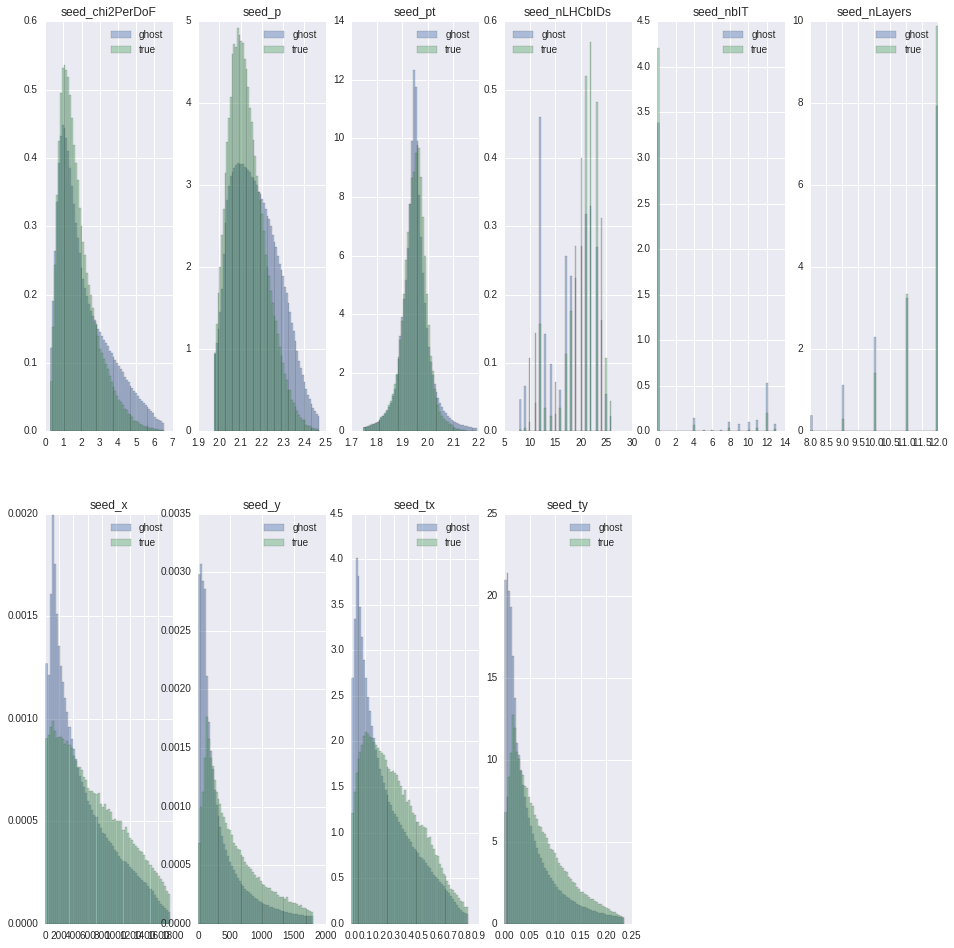

In [8]:
print_features_histograms(features, target)

In [16]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


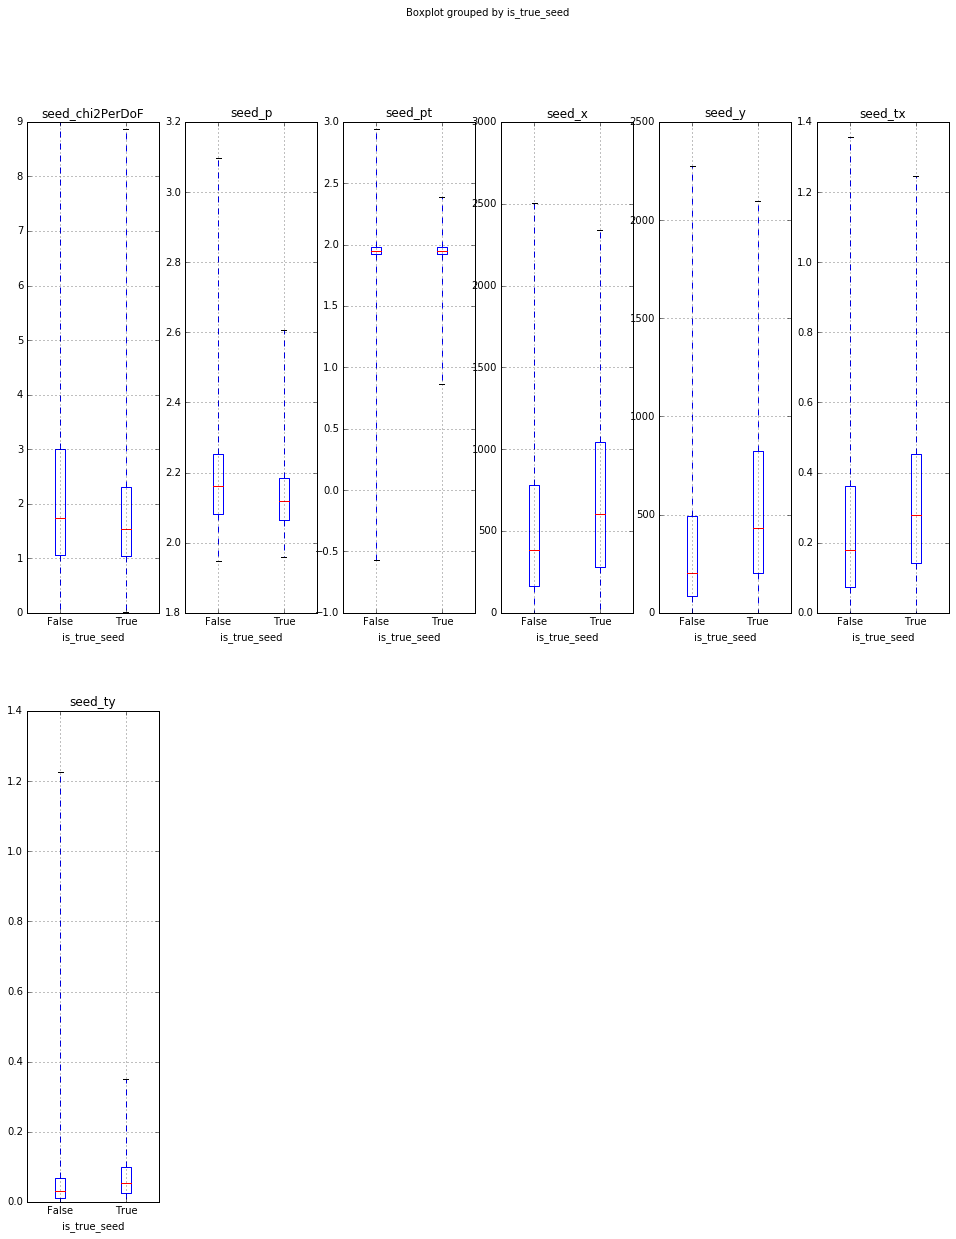

In [17]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

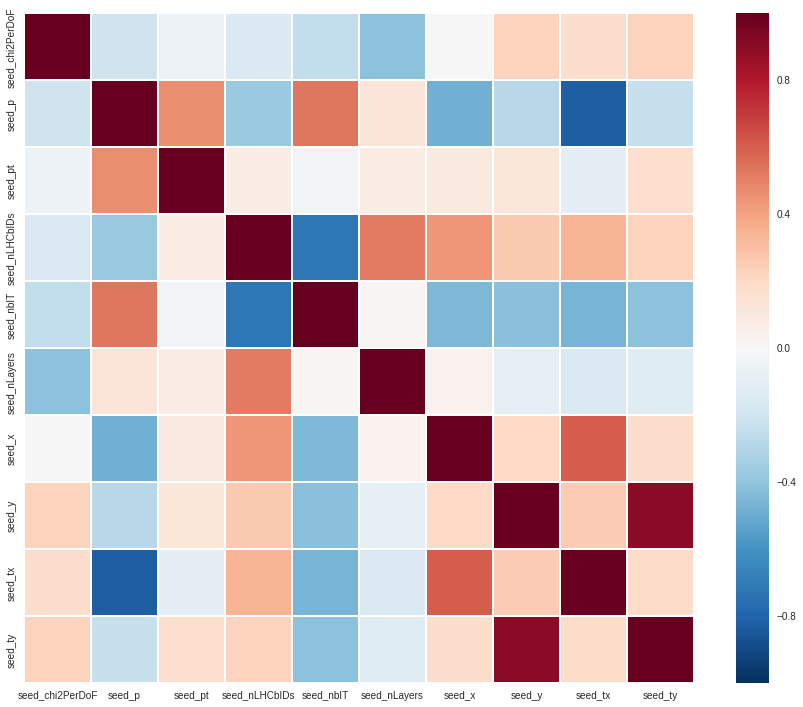

In [9]:
cor_mat = features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

Training of the basic version of the Logistic Regresion
=======================

Split data into train and validation sets
----------------------

In [5]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

In [8]:
clf = linear_model.LogisticRegression()
clf.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
roc_auc_score(testY, clf.predict_proba(testX)[:, 1])

0.73096862944613772

In [13]:
scores = cross_validation.cross_val_score(clf,
                                          testX, testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.73054 (+/- 0.00223)


In [14]:
def print_roc_curve(classifiers, cls_names, validX, validY):
    for classifier, cls_name in zip(classifiers, cls_names):
        fpr, tpr, thresholds = roc_curve(validY, classifier.predict_proba(validX)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=[6, 6])
        plt.plot(fpr, tpr, lw=1, label='ROC %(name)s (area = %(area)0.2f)'%{'name':cls_name,'area':roc_auc })
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

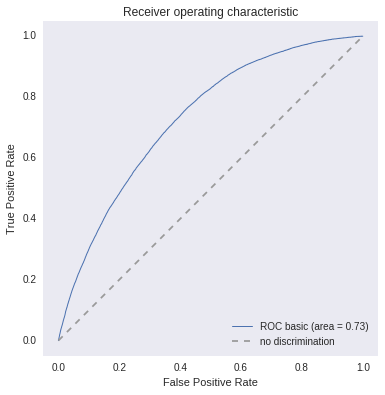

In [15]:
classifiers=[clf]
cls_names = ['basic']
print_roc_curve(classifiers,cls_names,testX,testY)

Nice result, without any feature engeenering and parameter optimalization! Just for free! 10% better than kNN

Now, Let's try to scale all features
-------------------

In [5]:
scaled_trainX, scaled_testX, scaled_trainY, scaled_testY = train_test_split(features, target, random_state=42,train_size=0.9 )

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4))
])

In [43]:
clf_scaled.fit(scaled_trainX, scaled_trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [44]:
roc_auc_score(scaled_testY, clf_scaled.predict_proba(scaled_testX)[:, 1])

0.73171446399734696

In [46]:
scores = cross_validation.cross_val_score(clf_scaled,
                                          scaled_testX, scaled_testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

We have small improvement by 0.5% 

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring='roc_auc' , n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

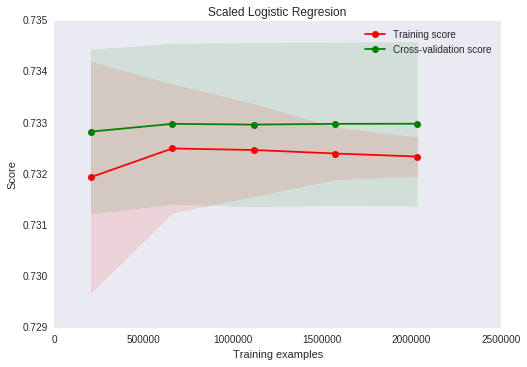

In [47]:
cv = cross_validation.ShuffleSplit(scaled_trainX.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
plot_learning_curve(clf_scaled, 'Scaled Logistic Regresion',scaled_trainX,scaled_trainY, cv =cv )

Play with regularization constans
==============
At first ry to optimalize L1 regularization 
----------------
I use LogisticRegressionCV as a model. It can optimalize strength of regularization in a very easy way. 
Ofcourse as I need to scale the features at first. 

The regularization scale are in range 10^-3 - 100 with pseudologaritmical step 


In [ ]:
cv = cross_validation.ShuffleSplit(scaled_trainX.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

Cs= [0.001,0.003,
    0.01, 0.03,
    0.1,0.3,
    1,3,
    10,30]

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l1'))
])


train_scores, test_scores = validation_curve(
    clf_scaled, features, target, param_name="classification__C", param_range=Cs,
    cv=cv, scoring="roc_auc", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)        

In [62]:
train_scores_mean

array([ 0.73171422,  0.73218308,  0.73234372,  0.73238517,  0.73239823,
        0.73240185,  0.73240307,  0.73240343,  0.73240356,  0.73240359])

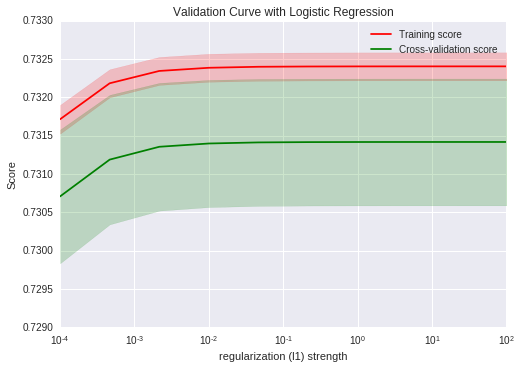

In [65]:
param_range = np.logspace(-4, 2,10)
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("regularization (l1) strength")
plt.ylabel("Score")
plt.ylim(0.729, 0.733)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show() 

Conclusion for L1 study. There is no impact on classifier performance the C > 0.01 

Similar study for L2 regularization.
---------------
The classifier should have worst performance due to distribution of the features. 

In [66]:
cv = cross_validation.ShuffleSplit(scaled_trainX.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

Cs= [0.001,0.003,
    0.01, 0.03,
    0.1,0.3,
    1,3,
    10,30]

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l2'))
])


train_scores, test_scores = validation_curve(
    clf_scaled, features, target, param_name="classification__C", param_range=Cs,
    cv=cv, scoring="roc_auc", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)  

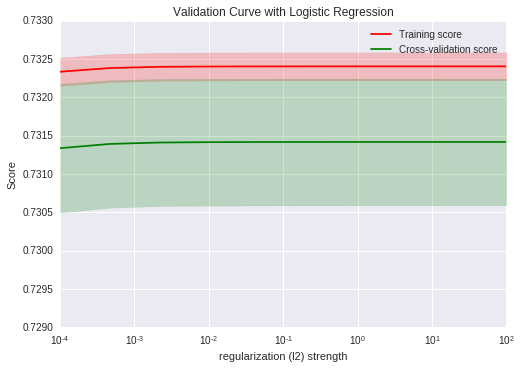

In [67]:
param_range = np.logspace(-4, 2,10)
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("regularization (l2) strength")
plt.ylabel("Score")
plt.ylim(0.729, 0.733)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show() 

Add Polynomian features
==================
Add second order of magnitudes polynomian features

In [6]:
clf_polynomian = Pipeline([
          ('feature_scale', StandardScaler() ),
          ('polynomian', PolynomialFeatures(degree=2, include_bias = False)),
          ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l2'))
])

In [7]:
scaled_trainX, scaled_testX, scaled_trainY, scaled_testY = train_test_split(features, target, random_state=42,train_size=0.9 )
clf_polynomian.fit(scaled_trainX, scaled_trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomian', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('classification', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [8]:
roc_auc_score(scaled_testY, clf_polynomian.predict_proba(scaled_testX)[:, 1])

0.76916808374092449

In [9]:
scores = cross_validation.cross_val_score(clf_polynomian,
                                          scaled_testX, scaled_testY,
                                          scoring="roc_auc",
                                          n_jobs=1,
                                          cv=3);

In [13]:
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

In [14]:
clf_polynomian.named_steps["classification"].coef_

array([[-0.24216665, -0.12108157, -0.167441  ,  0.53684399,  2.94554264,
         0.10420117,  0.50701989,  2.05610043,  0.50538042, -0.09140612,
        -0.0527873 ,  0.09442257,  0.00735738,  0.38700668,  0.3530633 ,
        -0.01501503,  0.07134768,  0.07458057,  0.12675664, -0.1592975 ,
        -0.23032478,  0.24102284, -0.21377306,  0.22738731,  0.16455587,
         0.14576569, -0.08025773, -0.12408193, -0.52504452, -0.08311093,
        -0.08974108, -0.25553556, -0.03470741,  0.03801435, -0.16937656,
         0.2151244 ,  0.31842814, -0.25612029, -0.51300074, -0.16338468,
        -0.2039012 , -0.02668198,  0.00571897,  0.21436611, -0.08290003,
        -0.08367173,  0.35510136,  3.31514124,  1.14235878, -0.30632898,
         0.0352947 ,  0.0142373 , -0.09318202,  0.09249788,  0.0628316 ,
         0.0209991 , -0.36016193,  0.04483312,  0.328683  , -0.79573878,
         0.7611776 ,  1.34676769, -0.01625113, -0.83848348, -0.68721582]])

Replace redundant feature
------------------------
I reduce phasespace into only important feature. At first I need to display new data, classifier feature importance. 
Based on this value I set the threshold for reduce feature dementionality. 

In [142]:
feature_transformator = Pipeline([
          ('feature_scale', StandardScaler() ),
          ('polynomian', PolynomialFeatures(degree=2, include_bias = False))
         ])
feature_transformator.fit(features)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) 
                                  for pair in tuple if pair[1]!=0])
                                    for tuple in [zip(features.columns,p)
                                      for p in feature_transformator.named_steps["polynomian"].powers_]]
polynomian_data = pd.DataFrame(feature_transformator.transform(features), columns = target_feature_names)
polynomian_data.head()

,seed_chi2PerDoF^1,seed_p^1,seed_pt^1,seed_nLHCbIDs^1,seed_nbIT^1,seed_nLayers^1,seed_x^1,seed_y^1,seed_tx^1,seed_ty^1,...,seed_x^2,seed_x^1xseed_y^1,seed_x^1xseed_tx^1,seed_x^1xseed_ty^1,seed_y^2,seed_y^1xseed_tx^1,seed_y^1xseed_ty^1,seed_tx^2,seed_tx^1xseed_ty^1,seed_ty^2
0,-0.646599,-0.936503,0.037566,1.543562,-0.558618,0.769553,1.634587,0.331957,1.358366,0.209256,...,2.671873,0.542612,2.220367,0.342048,0.110195,0.450919,0.069464,1.845159,0.284247,0.043788
1,-0.555312,-0.851997,0.064420,1.543562,-0.558618,0.769553,1.637642,-0.673015,1.144448,-0.780860,...,2.681870,-1.102157,1.874196,-1.278769,0.452949,-0.770231,0.525530,1.309762,-0.893654,0.609742
2,-0.361215,-0.342581,0.719919,1.543562,-0.558618,0.769553,2.211965,-0.440458,0.669760,-0.462199,...,4.892790,-0.974278,1.481486,-1.022368,0.194003,-0.295001,0.203579,0.448579,-0.309563,0.213628
3,-0.249799,-0.260404,0.842481,1.543562,-0.558618,0.769553,2.306098,0.251636,0.605838,0.156093,...,5.318087,0.580296,1.397121,0.359965,0.063320,0.152450,0.039278,0.367039,0.094567,0.024365
4,-0.608313,-1.031164,0.137969,1.329566,-0.558618,0.769553,2.482001,0.076641,1.954403,0.084912,...,6.160329,0.190223,4.850829,0.210752,0.005874,0.149788,0.006508,3.819690,0.165953,0.007210


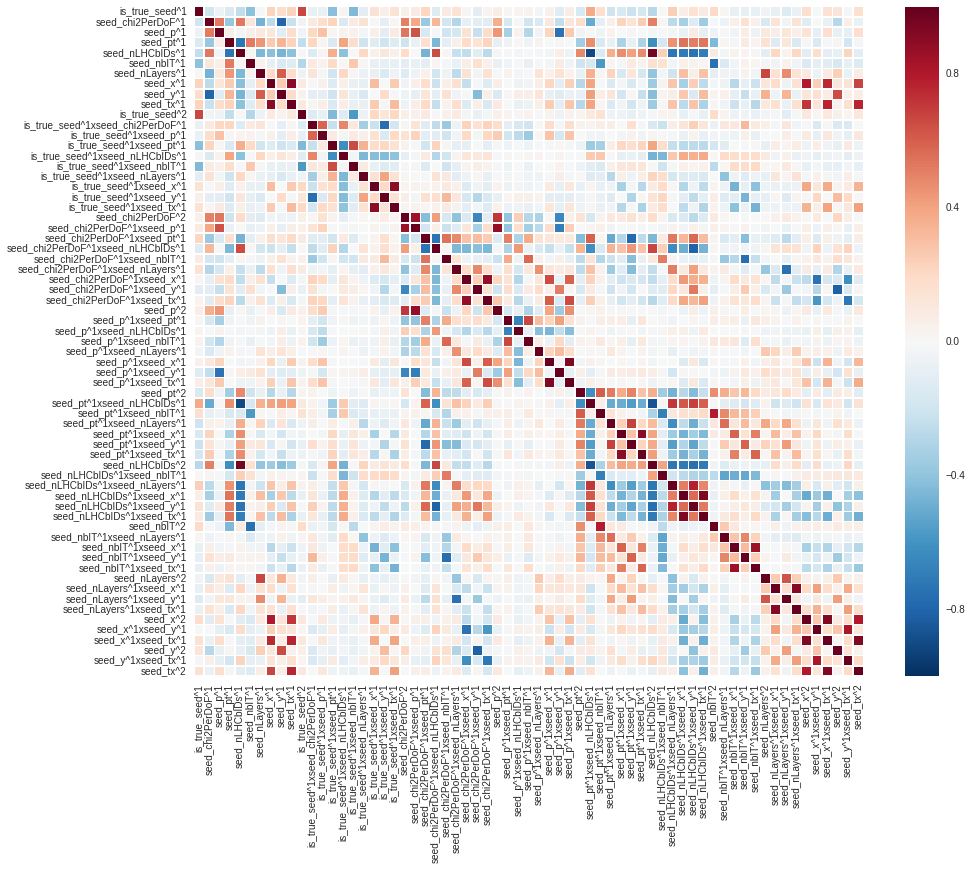

In [17]:
cor_mat = polynomian_data.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

In [209]:
def print_feature_importance(model, features_names):
    importances = model.coef_.ravel()
    #indices = numpy.argsort(np.abs(importances))[::-1].ravel()
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(len(features_names)):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[f]))

    # Plot the feature importances of the forest
    plt.figure()
    f, ax = plt.subplots(figsize=(15, 12))
    plt.title("Feature importances")
    plt.bar(range(len(features_names)), importances, color="r")
    plt.xticks(range(len(features_names)), features_names, rotation=70)
    plt.xlim([-1, len(features_names) ])
    plt.show()

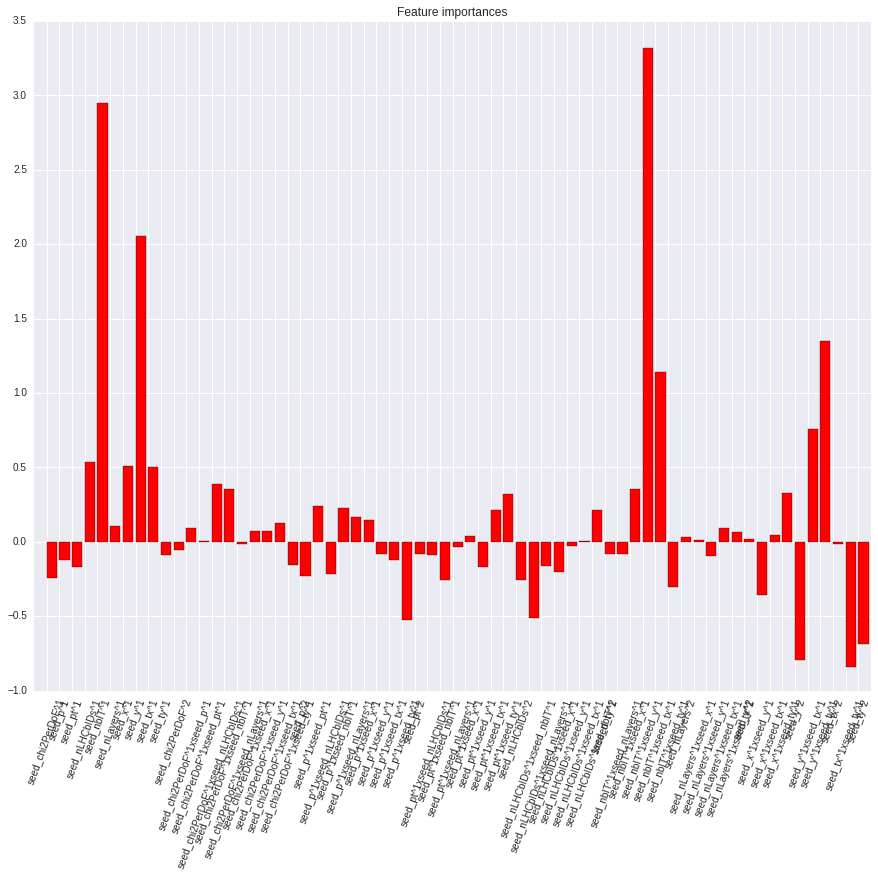

In [194]:
print_feature_importance(clf_polynomian.named_steps["classification"], target_feature_names)

Select only important features. 

In [197]:
importances = clf_polynomian.named_steps["classification"].coef_.ravel()
threshold = 0.1
unimportant_features = [target_feature_names[i] for i in range(len(target_feature_names)) if abs(importances[i]) <threshold]
unimportant_features

['seed_ty^1',
 'seed_chi2PerDoF^2',
 'seed_chi2PerDoF^1xseed_p^1',
 'seed_chi2PerDoF^1xseed_pt^1',
 'seed_chi2PerDoF^1xseed_nLayers^1',
 'seed_chi2PerDoF^1xseed_x^1',
 'seed_chi2PerDoF^1xseed_y^1',
 'seed_p^1xseed_y^1',
 'seed_pt^2',
 'seed_pt^1xseed_nLHCbIDs^1',
 'seed_pt^1xseed_nLayers^1',
 'seed_pt^1xseed_x^1',
 'seed_nLHCbIDs^1xseed_y^1',
 'seed_nLHCbIDs^1xseed_tx^1',
 'seed_nbIT^2',
 'seed_nbIT^1xseed_nLayers^1',
 'seed_nLayers^2',
 'seed_nLayers^1xseed_x^1',
 'seed_nLayers^1xseed_y^1',
 'seed_nLayers^1xseed_tx^1',
 'seed_nLayers^1xseed_ty^1',
 'seed_x^2',
 'seed_x^1xseed_tx^1',
 'seed_tx^2']

In [198]:
important_polynomian_data=polynomian_data.drop(unimportant_features,axis=1)
important_polynomian_data.head()

,seed_chi2PerDoF^1,seed_p^1,seed_pt^1,seed_nLHCbIDs^1,seed_nbIT^1,seed_nLayers^1,seed_x^1,seed_y^1,seed_tx^1,seed_chi2PerDoF^1xseed_nLHCbIDs^1,...,seed_nbIT^1xseed_y^1,seed_nbIT^1xseed_tx^1,seed_nbIT^1xseed_ty^1,seed_x^1xseed_y^1,seed_x^1xseed_ty^1,seed_y^2,seed_y^1xseed_tx^1,seed_y^1xseed_ty^1,seed_tx^1xseed_ty^1,seed_ty^2
0,-0.646599,-0.936503,0.037566,1.543562,-0.558618,0.769553,1.634587,0.331957,1.358366,-0.998065,...,-0.185437,-0.758808,-0.116894,0.542612,0.342048,0.110195,0.450919,0.069464,0.284247,0.043788
1,-0.555312,-0.851997,0.064420,1.543562,-0.558618,0.769553,1.637642,-0.673015,1.144448,-0.857158,...,0.375958,-0.639309,0.436202,-1.102157,-1.278769,0.452949,-0.770231,0.525530,-0.893654,0.609742
2,-0.361215,-0.342581,0.719919,1.543562,-0.558618,0.769553,2.211965,-0.440458,0.669760,-0.557558,...,0.246048,-0.374140,0.258193,-0.974278,-1.022368,0.194003,-0.295001,0.203579,-0.309563,0.213628
3,-0.249799,-0.260404,0.842481,1.543562,-0.558618,0.769553,2.306098,0.251636,0.605838,-0.385580,...,-0.140568,-0.338432,-0.087196,0.580296,0.359965,0.063320,0.152450,0.039278,0.094567,0.024365
4,-0.608313,-1.031164,0.137969,1.329566,-0.558618,0.769553,2.482001,0.076641,1.954403,-0.808792,...,-0.042813,-1.091764,-0.047433,0.190223,0.210752,0.005874,0.149788,0.006508,0.165953,0.007210


In [199]:
polynomian_important_clf = linear_model.LogisticRegression(tol=1e-4 , penalty='l2') 

In [203]:
important_trainX, important_testX, important_trainY, important_testY = train_test_split(important_polynomian_data, target, random_state=42,train_size=0.9 )
polynomian_important_clf.fit(important_trainX, important_trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [205]:
roc_auc_score(important_testY, polynomian_important_clf.predict_proba(important_testX)[:, 1])

0.76763467806915342

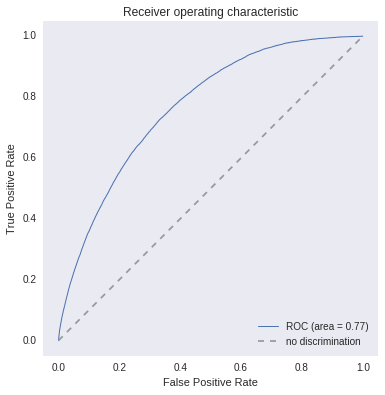

In [206]:
fpr, tpr, thresholds = roc_curve(important_testY, polynomian_important_clf.predict_proba(important_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

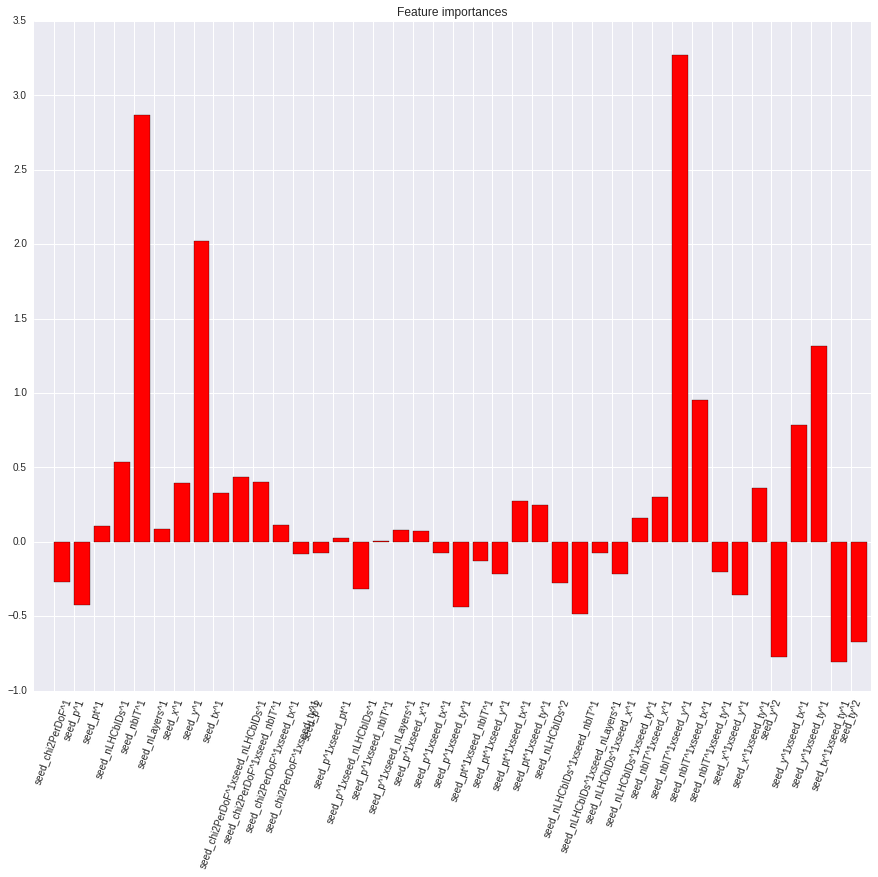

In [210]:
print_feature_importance(polynomian_important_clf,important_polynomian_data.columns.values)

Regularization Study
=====================
Let's take care about regularization strainght I suppose it can have more influence than in the previous study. Right now we have a lot of features. 
L1 as a first step
-------------------